In [1]:
import torch
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [81]:
from PIL import Image

from torch.utils.data import Dataset
import torchvision.transforms as transforms
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

def encode_label(label):
  if label == 'background':
    return 0
  elif label == 'dart':
    return 1
  elif label == 'anchor':
    return 2
  else:
    raise ValueError(f'unknown label {label}')

def collate(batch):
  images = []
  bboxes = []
  labels = []

  # Find the maximum number of objects in the batch
  max_objects = max(sample["bboxes"].size(0) for sample in batch)
  #print(f"max objects {max_objects} in batch of size {len(batch)}")

  for sample in batch:
      image = sample["image"]
      batch_bboxes = sample["bboxes"]
      labels_data = sample["labels"]

      # Pad objects and labels to match the maximum object count
      padded_bboxes = torch.cat(
          (
              batch_bboxes,
              torch.zeros(
                  max_objects - batch_bboxes.size(0), batch_bboxes.size(1)
              ),
          )
      )
      #print(f"label size {labels_data.size()}")
      #print(f"label data {labels_data}")
      padded_labels = torch.cat(
          (
              labels_data,
              torch.zeros(max_objects - labels_data.size(0))
          )
      )

      images.append(image)
      bboxes.append(padded_bboxes)
      labels.append(padded_labels)

  # Convert images, objects, and labels to tensors
  images = torch.stack(images)
  bboxes = torch.stack(bboxes)
  labels = torch.stack(labels)

  return images, bboxes, labels

class DartnetDataset(Dataset):
  def __init__(self, info, device='cpu', img_transforms=[]):
      self.info = info
      self.device = device
      self.transform = img_transforms

  def __len__(self):
    return len(self.info)

  def bounding_box_transform(self, bbox):
    """
    in:  [[x0, y0], [x1, y1]]
    out: [x, y, width, height]
    """
    start, end = bbox
    width = end[0] - start[0]
    height = end[1] - start[1]
    return [start[0], start[1], width, height]

  def bounding_box_transform_end_point(self, bbox):
    """
    in:  [[x0, y0], [x1, y1]]
    out: [x0, y0, x1, y1]
    """
    start, end = bbox
    return [start[0], start[1], end[0], end[1]]

  def __getitem__(self, idx):
    item = self.info.iloc[idx]

    image_path = item["image_filename"]

    bboxes = []
    labels = []
    print('annotations')
    for a in item["annotations"]:
        box = a["bbox"]

        # TODO: temporary
        x, y = box
        offset = 40
        x0 = x - offset
        y0 = y - offset
        x1 = x + offset
        y1 = y + offset
        # bb has format x0, y0, x1, y1
        #x0, y0, x1, y1 = box
        bboxes.append(
            BoundingBox(
                x1=x0,
                y1=y0,
                x2=x1,
                y2=y1,
            )
        )
        labels.append(a["label"])
    encoded_labels = [ encode_label(l) for l in labels ]
    labels_tensor = torch.tensor(encoded_labels)

    # load image as tensor
    image = Image.open(image_path)
    # Convert RGBA image to RGB
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    width, height = image.size
    bboxes = BoundingBoxesOnImage(bboxes, shape=(height, width))

    image = transforms.PILToTensor()(image).numpy().transpose((1, 2, 0))

    #print(f"bbox before {bboxes}, transform {self.transform}")
    img_aug, bboxes_aug = self.transform(image=image, bounding_boxes=bboxes)
    #print(f"bbox after {bboxes_aug}")

    img_aug = img_aug.transpose((2, 0, 1))
    img_aug = torch.from_numpy(img_aug).to(torch.float32)

    # TODO, use this encoding of bboxes
    bbox_tensor = torch.tensor([self.bounding_box_transform_end_point(bbox) for bbox in bboxes_aug])

    info = {
        "image_filename": item["image_filename"],
        "image_labels": labels,
        "encoded_labels": encoded_labels
    }

    return {
        "image": img_aug,
        "bboxes": bbox_tensor,
        "labels": labels_tensor,
    }

In [41]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from torchvision.transforms import ToPILImage, Normalize

def build_anchor_offsets(n_anchors, img_width, img_height, grid_size):
    """
    Build anchor offsets.
    In each grid cell, generate n_anchors offsets.
    Squared and constant shape.
    offset in form x0, y0, x1, y1
    offset not normalized, uses img_size as base
    """
    
    cell_width = img_width / grid_size
    cell_height = img_height / grid_size

    # squared anchor offsets, 
    bbox_width = cell_width / 2
    bbox_height = cell_height / 2

    step_size_x = cell_width / n_anchors
    step_size_y = cell_height / n_anchors
    
    res = []
    for x in range(grid_size):
        s_pos_x = x * cell_width
        for y in range(grid_size):
            s_pos_y = y * cell_height
            for n in range(n_anchors):
                anchor_x_0 = s_pos_x + n * step_size_x
                anchor_x_1 = s_pos_x + n * step_size_x + bbox_width
                anchor_y_0 = s_pos_y + n * step_size_y
                anchor_y_1 = s_pos_y + n * step_size_y + bbox_height
                res.append([anchor_x_0, anchor_y_0, anchor_x_1, anchor_y_1])
    return torch.tensor(res)

def show_tensor(base_img_tensor):
    img = base_img_tensor.cpu() / 255
    img = ToPILImage()(img)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

def plot_boxes(base_img_tensor, bounding_boxes):
    img = base_img_tensor.cpu() / 255
    img = ToPILImage()(img)
    
    plt.imshow(img)

     # Plot bounding boxes
    for box in bounding_boxes:
        x0, y0, x1, y1 = box
        width = x1 - x0
        height = y1 - y0
        rect = patches.Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
    
    plt.show()

def plot_diff_boxes(base_img_tensor, boxes_lst):
    img = base_img_tensor.cpu() / 255
    img = ToPILImage()(img)
    
    plt.imshow(img)

     # Plot bounding boxes
    for (bounding_boxes, c) in boxes_lst:
        for box in bounding_boxes:
            x0, y0, x1, y1 = box
            width = x1 - x0
            height = y1 - y0
            rect = patches.Rectangle((x0, y0), width, height, linewidth=1, edgecolor=c, facecolor='none')
            plt.gca().add_patch(rect)
    
    plt.show()

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
from torchvision.models import resnet34, ResNet34_Weights    

class DartnetSSD(nn.Module):
    def __init__(
        self,
        n_classes,
        num_anchors,
        offsets,
        resnet_base=resnet34(weights=ResNet34_Weights.IMAGENET1K_V1),
    ):
        super(DartnetSSD, self).__init__()

        self.n_classes = n_classes
        self.n_anchors = num_anchors
        print("SSD Net configuration: ")
        print("n_classes", n_classes)
        print("num_anchors", num_anchors)

        # Remove the last fully connected layer and average pooling layer of the ResNet model
        modules = list(resnet_base.children())[:-2]
        self.base_model = nn.Sequential(*modules)

        self.extra_layers = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        self.bbox_offsets = offsets
        
        # SSD head layers for class prediction
        self.class_conv = nn.Conv2d(
            512, self.n_classes * n_anchors, kernel_size=3, padding=1
        )

        # SSD head layers for box prediction
        self.box_conv = nn.Conv2d(512, 4 * n_anchors, kernel_size=3, padding=1)
        self.offsets = offsets

    def forward(self, x):
        print('Input shape', x.shape)

        features = self.base_model(x)
        print("features.shape", features.shape)

        features = self.extra_layers(features)
        print("features.shape", features.shape)

        # Class prediction
        class_scores = self.class_conv(features)
        class_scores = class_scores.permute(0, 2, 3, 1).contiguous()
        class_scores = class_scores.view(class_scores.size(0), -1, self.n_classes)

        # Box prediction
        box_coords = self.box_conv(features)
        box_coords = box_coords.permute(0, 2, 3, 1).contiguous()
        box_coords = box_coords.view(box_coords.size(0), -1, 4)

        #print("predicted boxes", box_coords.shape, box_coords)
        #print("offset", self.offsets.shape, self.offsets)
        adjusted_boxes = box_coords + self.offsets
        #print("adjusted boxes", adjusted_boxes.shape, adjusted_boxes)

        return adjusted_boxes, class_scores

In [6]:
### Loss
import torch
import torchvision.ops as ops
import torch.nn as nn
import torch.nn.functional as F


def match_boxes(anchor_boxes, gt_boxes, iou_threshold=0.25):
    """
    Match anchor boxes to ground truth boxes based on IoU criteria.

    Args:
        anchor_boxes (Tensor): Anchor boxes with shape (N, 4), where N is the number of anchor boxes.
        gt_boxes (Tensor): Ground truth boxes with shape (M, 4), where M is the number of ground truth boxes.
        iou_threshold (float): IoU threshold for matching anchor boxes to ground truth boxes.

    Returns:
        matched_idxs (Tensor): Indices of ground truth boxes with most overlap, with shape (N).
        positive_mask (Tensor): Mask indicating positive iou threshold, with shape (N,).
    """
    num_anchors = anchor_boxes.size(0)
    num_gt_boxes = gt_boxes.size(0)

    if num_anchors == 0 or num_gt_boxes == 0:
        return torch.zeros(num_anchors, dtype=torch.int64), torch.zeros(
            num_anchors, dtype=torch.uint8
        )

    print(f"shape of anchor_boxes: {anchor_boxes.shape}")
    print(f"shape of gt_boxes: {gt_boxes.shape}")
    iou_matrix = ops.box_iou(anchor_boxes, gt_boxes)
    #print("iou_matrix", iou_matrix)

    max_iou_values, matched_idxs = iou_matrix.max(dim=1)
    positive_mask = max_iou_values >= iou_threshold

    print(f"shape of iou_matrix: {iou_matrix.shape}")
    print(f"shape of matched_idxs: {matched_idxs.shape}")
    print(f"shape of positive_mask: {positive_mask.shape}")

    return matched_idxs, positive_mask


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, prediction, label):
        predicted_classes, predicted_boxes = prediction
        label_classes, label_boxes = label

        print(f"shape of predicted_classes: {predicted_classes.shape}")
        print(f"shape of predicted_boxes: {predicted_boxes.shape}")

        batch_matched_idxs, batch_positive_masks = [], []

        batch_size = predicted_boxes.size(0)
        print(f"batch_size: {batch_size}")
        for i in range(batch_size):
            matched_idxs, positive_mask = match_boxes(
                predicted_boxes[i], label_boxes[i]
            )
            batch_matched_idxs.append(matched_idxs)
            batch_positive_masks.append(positive_mask)
            print("end iteration", i)
        batch_matched_idxs = torch.stack(batch_matched_idxs)
        batch_positive_masks = torch.stack(batch_positive_masks)

        print(f"shape of batch positive masks: {batch_positive_masks.shape}")

        pos_pred_classes = predicted_classes[batch_positive_masks]
        pos_label_classes = label_classes[batch_positive_masks]

        pos_pred_boxes = predicted_boxes[batch_positive_masks]
        pos_label_boxes = label_boxes[batch_positive_masks]

        print(f"shape of pos_pred_classes: {pos_pred_classes.shape}")
        print(f"shape of pos_label_classes: {pos_label_classes.shape}")
        print(f"shape of pos_pred_boxes: {pos_pred_boxes.shape}")
        print(f"shape of pos_label_boxes: {pos_label_boxes.shape}")

        return self.loss(
            pos_pred_boxes, pos_pred_classes, pos_label_boxes, pos_label_classes
        )

    def loss(self, loc_preds, cls_preds, loc_labels, cls_labels):
        # Localization loss (Smooth L1 Loss)
        loc_loss = F.smooth_l1_loss(loc_preds, loc_labels)

        # Classification loss (Focal Loss)
        cls_loss = self.focal_loss(cls_preds, cls_labels)

        # Total loss
        loss = loc_loss + cls_loss
        return loss

    def focal_loss(self, preds, labels):
        # Compute one-hot encoded targets
        one_hot = F.one_hot(labels, num_classes=preds.size(-1)).float()

        # Compute probabilities and weights for focal loss
        probs = torch.sigmoid(preds)
        pt = torch.where(one_hot == 1, probs, 1 - probs)
        alpha = torch.where(one_hot == 1, self.alpha, 1 - self.alpha)

        # Compute focal loss
        loss = -alpha * (1 - pt) ** self.gamma * torch.log(pt)

        # Sum the loss along the class dimension
        cls_loss = loss.sum(dim=-1)

        return cls_loss.mean()

In [7]:
folder = 'drive/MyDrive/' if IN_COLAB else ''
folder += 'dartnet_data/'
filename = folder + 'labels.json'
filename

'dartnet_data/labels.json'

In [23]:
###
### Load data
###
import json

import pandas as pd

with open(filename, 'r') as f:
    df = json.load(f)
    df = pd.DataFrame(df['labels'])
df

,image_filename,annotations
0,dartnet_data/dart_0_1.png,"[{'bbox': [843, 210], 'label': 'dart'}, {'bbox..."
1,dartnet_data/dart_0_2.png,"[{'bbox': [843, 210], 'label': 'dart'}, {'bbox..."
2,dartnet_data/dart_0_3.png,"[{'bbox': [843, 210], 'label': 'dart'}, {'bbox..."
3,dartnet_data/dart_1_1.png,"[{'bbox': [401, 458], 'label': 'dart'}, {'bbox..."
4,dartnet_data/dart_1_2.png,"[{'bbox': [401, 458], 'label': 'dart'}, {'bbox..."
5,dartnet_data/dart_1_3.png,"[{'bbox': [401, 458], 'label': 'dart'}, {'bbox..."
6,dartnet_data/dart_2_1.png,"[{'bbox': [374, 112], 'label': 'dart'}, {'bbox..."
7,dartnet_data/dart_2_2.png,"[{'bbox': [374, 112], 'label': 'dart'}, {'bbox..."
8,dartnet_data/dart_2_3.png,"[{'bbox': [374, 112], 'label': 'dart'}, {'bbox..."
9,dartnet_data/dart_3_1.png,"[{'bbox': [584, 474], 'label': 'dart'}, {'bbox..."


In [24]:
from tqdm.notebook import tqdm

def fit(model, dataloaders, criterion, optimizer, scheduler, n_epochs, device='cuda'):
  model.to(device)
  n_train = len(dataloaders['train'].dataset)
  n_val = len(dataloaders['val'].dataset)

  print(f"Will train for {n_epochs} epochs. {n_train} train and {n_val} val samples")


  for epoch in range(n_epochs):
    for phase in ['train', 'val']:
      running_loss = 0.0
      sampels = 0
      dataloader = dataloaders[phase]

      if phase == 'train':
        model.train()
      else:
        model.eval()

      for images, bboxes, labels in tqdm(dataloader):
        images, gt_bboxes, class_labels = images.to(device), bboxes.to(device), labels.to(device)

        optimizer.zero_grad()

        # forward
        print(images.shape)
        bboxes, scores = model(images)
        loss = criterion((bboxes, scores), (gt_bboxes, class_labels))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        samples += images.size(0)
      epoch_loss = running_loss / samples

      scheduler.step()
      print(f'Epoch {epoch}-{phase}\t: loss: {epoch_loss}')

In [74]:
###
### Train
###
import imgaug.augmenters as iaa
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchinfo import summary

###
### windoof
###
import os
if os.name == 'nt':
    workers = 0
else:
    workers = 4
print(f'using {workers} workers')

batch_size = 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

t_train = iaa.Sequential([
    iaa.Resize({'height': 244, 'width': 244})
])

t_val = iaa.Sequential([
    iaa.Resize({'height': 244, 'width': 244})
])

train_dataset = DartnetDataset(df, device, img_transforms=t_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers, collate_fn=collate)
val_dataloader = DataLoader(train_dataset, batch_size=1, num_workers=workers, collate_fn=collate)

dataloaders = { 'train': train_dataloader, 'val': val_dataloader }

n_anchors = 1
offsets = build_anchor_offsets(n_anchors, 244, 244, 4).to(device)
offsets = offsets.unsqueeze(0)
model = DartnetSSD(3, n_anchors, offsets)
#print(summary(model,
#              input_size=(batch_size, 3, 244, 244),
#              col_names=["kernel_size", "input_size", "output_size", "num_params"],
#              row_settings=["var_names"],
#              depth=4))

from loss import PushkinLoss
criterion = PushkinLoss()


optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 12, eta_min=0, last_epoch=-1)

n_epochs = 100

fit(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer, scheduler=scheduler, device='cuda', n_epochs=n_epochs)

using 0 workers
SSD Net configuration: 
n_classes 3
num_anchors 1
Will train for 100 epochs. 30 train and 30 val samples


  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([1, 3, 244, 244])
Input shape torch.Size([1, 3, 244, 244])
features.shape torch.Size([1, 512, 8, 8])
features.shape torch.Size([1, 512, 4, 4])
shape of predicted_classes: torch.Size([1, 16, 3])
shape of predicted_boxes: torch.Size([1, 16, 4])
batch_size: 1
shape of anchor_boxes: torch.Size([16, 4])
shape of gt_boxes: torch.Size([6, 4])
predicted_boxes: tensor([[-1.1618e-02,  1.5591e-01,  3.0614e+01,  3.0422e+01],
        [-7.4753e-02,  6.1116e+01,  3.0672e+01,  9.1498e+01],
        [-1.0694e-01,  1.2216e+02,  3.0619e+01,  1.5255e+02],
        [-3.9298e-02,  1.8309e+02,  3.0559e+01,  2.1354e+02],
        [ 6.1038e+01,  6.0503e-02,  9.1697e+01,  3.0579e+01],
        [ 6.0927e+01,  6.1143e+01,  9.1772e+01,  9.1664e+01],
        [ 6.0824e+01,  1.2217e+02,  9.1714e+01,  1.5249e+02],
        [ 6.0833e+01,  1.8308e+02,  9.1644e+01,  2.1329e+02],
        [ 1.2206e+02, -7.8629e-03,  1.5273e+02,  3.0541e+01],
        [ 1.2173e+02,  6.1048e+01,  1.5274e+02,  9.1622e+01],
        [ 1.21

IndexError: The shape of the mask [1, 16] at index 1 does not match the shape of the indexed tensor [1, 6] at index 1

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

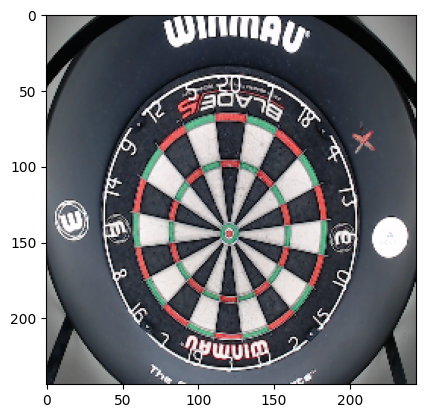

In [46]:
t = train_dataset[0]
img = t['image']


plot_boxes(img, offsets[0, :, :])

In [ ]:
r = model(img.unsqueeze(0).to('cuda'))
r[0].shape, r[1].shape, len(offsets)

In [ ]:
m = DartnetSSD(3, 3).to('cuda')

In [ ]:
inpu = torch.rand((3, 3, 244, 244)).to('cuda')
inpu.shape

In [ ]:
a = torch.tensor([[[1,2], [3, 4], [5,6]], [[1,2], [3, 4], [5,6]]])
print(a.shape)
off = torch.tensor([[1,1], [2,2], [-3, 3]])
b = a + off
b

In [ ]:
t = torch.randn([8, 15, 4, 4])
print(t.shape)
t = t.permute(0, 2, 3, 1).contiguous()
t = t.view(t.size(0), -1, 3)
print(t.shape)

annotations
Input shape torch.Size([1, 3, 244, 244])
features.shape torch.Size([1, 512, 8, 8])
features.shape torch.Size([1, 512, 4, 4])
pred torch.Size([16, 4]) tensor([[-3.5411e-02,  1.3664e-01,  3.0639e+01,  3.0440e+01],
        [-9.4950e-02,  6.1116e+01,  3.0663e+01,  9.1567e+01],
        [-8.7533e-02,  1.2212e+02,  3.0652e+01,  1.5258e+02],
        [-1.5581e-02,  1.8312e+02,  3.0564e+01,  2.1358e+02],
        [ 6.0994e+01,  6.3798e-02,  9.1652e+01,  3.0584e+01],
        [ 6.0912e+01,  6.1211e+01,  9.1746e+01,  9.1691e+01],
        [ 6.0895e+01,  1.2213e+02,  9.1690e+01,  1.5255e+02],
        [ 6.0841e+01,  1.8305e+02,  9.1657e+01,  2.1328e+02],
        [ 1.2208e+02, -2.1973e-02,  1.5267e+02,  3.0539e+01],
        [ 1.2170e+02,  6.1068e+01,  1.5272e+02,  9.1556e+01],
        [ 1.2180e+02,  1.2225e+02,  1.5260e+02,  1.5240e+02],
        [ 1.2191e+02,  1.8309e+02,  1.5249e+02,  2.1327e+02],
        [ 1.8298e+02, -4.2064e-02,  2.1360e+02,  3.0509e+01],
        [ 1.8263e+02,  6.0840e+0

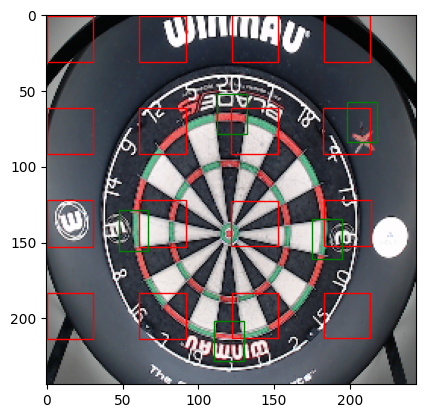

In [85]:
ds = DartnetDataset(df, device, img_transforms=t_train)
t = ds[0]
img = t['image'].unsqueeze(0)


boxes, _ = model(img.to(device))
boxes = boxes.detach().cpu()[0]
gt_boxes = t['bboxes']

print('pred', boxes.shape, boxes)
print("gt", gt_boxes.shape, gt_boxes)

iou_matrix = ops.box_iou(boxes, gt_boxes)
print("iou_matrix", iou_matrix)

plot_diff_boxes(img[0, :, :, :], [(boxes, 'r'), (gt_boxes, 'g')])